# Fraudulent Transaction Detection
---
Fraudulent activities in online transactions are becoming an increasing concern for the public, especially with the significant rise in reported cases. According to the latest data from the Financial Transaction Reports and Analysis Center (PPATK), the number of suspicious financial transaction reports (LKTM) has reached a staggering 130,472. This figure represents a substantial increase of 43.78% compared to the same period in the previous year, which recorded 90,742 reports.

In addressing the increasingly complex issue of online fraud, the role of data scientists is crucial. You are faced with the challenge of helping to reduce the prevalence of such fraudulent incidents in the future. Through participation in this playground, your task is not only to identify common characteristics of fraud perpetrators but also to develop a predictive model that can accurately identify individuals or transactions with a high potential for fraud based on the available data.

# Importing Data and Libraries
---

In [1]:
import os
from catboost import CatBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
base_path_dir = ''
try:
    os.listdir('/kaggle')
    base_path_dir = '/kaggle/input/datathon24playground/datathon-2024-playground'
except:
    base_path_dir = './datathon-2024-playground'
print("Base path:",base_path_dir)

Base path: /kaggle/input/datathon24playground/datathon-2024-playground


In [3]:
rename_dict = {
    'id_pengguna': 'user_id',
    'waktu_pendaftaran_akun': 'account_registration_time',
    'waktu_pembelian': 'purchase_time',
    'total_harga_pembelian': 'total_purchase_value',
    'id_perangkat': 'device_id',
    'sumber': 'source',
    'browser': 'browser_type',
    'gender': 'gender',
    'umur': 'age',
    'alamat_IP': 'ip_address',
    'fraud': 'fraud',
    'batas_bawah_alamat_IP': 'ip_lower_bound',
    'batas_atas_alamat_IP': 'ip_upper_bound',
    'negara': 'country'
}

In [4]:
train = pd.read_csv(os.path.join(base_path_dir, 'train.csv'))
train.rename(columns=rename_dict,inplace=True)

test = pd.read_csv(os.path.join(base_path_dir,'test.csv'))
test.rename(columns=rename_dict,inplace=True)

ip = pd.read_csv(os.path.join(base_path_dir,'ip_address_mapping.csv'))
ip.rename(columns=rename_dict,inplace=True)

# Data Description
---
The dataset consists of three files:

### 1. **train.csv** and **test.csv**

| Column Name               | Description                                                                 |
|---------------------------|-----------------------------------------------------------------------------|
| `user_id`                 | Unique identifier for each user registered on the e-commerce platform.     |
| `account_registration_time` | The time when the user registered on the e-commerce platform.             |
| `purchase_time`           | The time when the user made a purchase on the e-commerce platform.         |
| `total_purchase_value`    | The transaction value of the purchase made by the user.                    |
| `device_id`               | Unique identifier of the device used by the user to access the platform.   |
| `source`                  | The source or channel through which the user discovered or accessed the platform (e.g., advertisement, organic search, etc.). |
| `browser`                 | The type of browser used by the user to access the e-commerce platform.    |
| `gender`                  | The gender of the user registered on the platform.                         |
| `age`                     | The age of the user registered on the platform.                            |
| `ip_address`              | The IP address used by the user's device when accessing the platform.     |
| `fraud`                   | Classification of the transaction as fraudulent or not (Not available in test.csv). |

---

### 2. **ip_address_mapping.csv**

| Column Name               | Description                                                                 |
|---------------------------|-----------------------------------------------------------------------------|
| `ip_lower_bound`          | The lower bound of the IP address range used to determine the user's geographical location. |
| `ip_upper_bound`          | The upper bound of the IP address range used to determine the user's geographical location. |
| `country`                 | The country of origin of the user based on the IP address used to access the platform. |


## Train

In [5]:
train.head(5)

,user_id,account_registration_time,purchase_time,total_purchase_value,device_id,source,browser_type,gender,age,ip_address,fraud
0,286873,6/7/2015 12:58,9/27/2015 16:32,14,DNTIEECGGDXHF,Iklan,Opera,F,38,2.417207e+08,0
1,244392,5/1/2015 15:29,8/27/2015 14:21,11,MECRFNJGDPGOB,SEO,Chrome,M,36,4.172794e+09,0
2,20720,3/29/2015 18:04,6/13/2015 6:50,52,WLTSYVLLASJOZ,SEO,Internet Explorer,M,26,1.113433e+09,0
3,198755,1/29/2015 0:49,2/17/2015 21:49,13,TWGNWOWURZFMY,SEO,Safari,F,38,1.339309e+09,0
4,64996,1/17/2015 19:30,3/1/2015 9:17,23,XMQENRCEILYAJ,Langsung,Safari,F,19,4.602382e+08,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75556 entries, 0 to 75555
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    75556 non-null  int64  
 1   account_registration_time  75556 non-null  object 
 2   purchase_time              75556 non-null  object 
 3   total_purchase_value       75556 non-null  int64  
 4   device_id                  75556 non-null  object 
 5   source                     75556 non-null  object 
 6   browser_type               75556 non-null  object 
 7   gender                     75556 non-null  object 
 8   age                        75556 non-null  int64  
 9   ip_address                 75556 non-null  float64
 10  fraud                      75556 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 6.3+ MB


In [7]:
for col in train.select_dtypes('object'):
    print(f'DESCRIBING: {col}')
    print(train[col].unique())
    print(train[col].nunique())
    print('------------------')

DESCRIBING: account_registration_time
['6/7/2015 12:58' '5/1/2015 15:29' '3/29/2015 18:04' ... '2/18/2015 13:55'
 '4/15/2015 1:21' '1/5/2015 21:56']
70669
------------------
DESCRIBING: purchase_time
['9/27/2015 16:32' '8/27/2015 14:21' '6/13/2015 6:50' ... '5/29/2015 2:41'
 '7/29/2015 7:37' '5/21/2015 5:43']
66979
------------------
DESCRIBING: device_id
['DNTIEECGGDXHF' 'MECRFNJGDPGOB' 'WLTSYVLLASJOZ' ... 'TJYOHNTNXAMYU'
 'VGMIKGWQYPRPI' 'FAYIRBHTCRTHC']
71299
------------------
DESCRIBING: source
['Iklan' 'SEO' 'Langsung']
3
------------------
DESCRIBING: browser_type
['Opera' 'Chrome' 'Internet Explorer' 'Safari' 'Firefox']
5
------------------
DESCRIBING: gender
['F' 'M']
2
------------------


In [8]:
train.describe()

,user_id,total_purchase_value,age,ip_address,fraud
count,75556.000000,75556.000000,75556.000000,7.555600e+04,75556.000000
mean,200306.194994,36.862407,33.124649,2.152027e+09,0.079755
std,115197.966115,18.302404,8.625183,1.247912e+09,0.270916
min,4.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,101157.250000,22.000000,27.000000,1.086566e+09,0.000000
50%,200399.500000,34.000000,33.000000,2.151286e+09,0.000000
75%,299563.250000,49.000000,39.000000,3.243383e+09,0.000000
max,399995.000000,154.000000,73.000000,4.294822e+09,1.000000


## Test

In [9]:
test.head(5)

,user_id,account_registration_time,purchase_time,total_purchase_value,device_id,source,browser_type,gender,age,ip_address
0,28006,2015-06-26 13:27:55,2015-07-13 02:46:13,48,IVHYUSXPDUJUD,SEO,Chrome,M,31,4.268419e+09
1,245189,2015-06-23 15:48:00,2015-09-16 07:26:25,46,UJURCZHQSNBQA,SEO,Firefox,M,34,4.277726e+09
2,58345,2015-06-18 04:14:35,2015-09-21 22:24:59,30,PVWDQUCMMBJXJ,Iklan,Firefox,F,20,1.235071e+09
3,218574,2015-05-19 14:55:18,2015-08-21 00:44:36,29,PMSPHBOFWBTRC,Langsung,Safari,M,25,2.496396e+09
4,49779,2015-04-02 23:35:29,2015-07-08 06:24:47,19,NFGHLAQQPTLVY,Iklan,Chrome,M,38,2.701254e+09


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75556 entries, 0 to 75555
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    75556 non-null  int64  
 1   account_registration_time  75556 non-null  object 
 2   purchase_time              75556 non-null  object 
 3   total_purchase_value       75556 non-null  int64  
 4   device_id                  75556 non-null  object 
 5   source                     75556 non-null  object 
 6   browser_type               75556 non-null  object 
 7   gender                     75556 non-null  object 
 8   age                        75556 non-null  int64  
 9   ip_address                 75556 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 5.8+ MB


In [11]:
for col in test.select_dtypes('object'):
    print(f'DESCRIBING: {col}')
    print(test[col].unique())
    print(test[col].nunique())
    print('------------------')

DESCRIBING: account_registration_time
['2015-06-26 13:27:55' '2015-06-23 15:48:00' '2015-06-18 04:14:35' ...
 '2015-02-18 19:35:42' '2015-06-11 11:25:34' '2015-02-04 03:27:10']
75556
------------------
DESCRIBING: purchase_time
['2015-07-13 02:46:13' '2015-09-16 07:26:25' '2015-09-21 22:24:59' ...
 '2015-06-13 11:32:14' '2015-08-26 16:56:16' '2015-04-21 18:08:33']
75466
------------------
DESCRIBING: device_id
['IVHYUSXPDUJUD' 'UJURCZHQSNBQA' 'PVWDQUCMMBJXJ' ... 'VTNESIHQEDBVT'
 'AFAPNMPPJEHGS' 'EGNGWAPEJUMPO']
70126
------------------
DESCRIBING: source
['SEO' 'Iklan' 'Langsung']
3
------------------
DESCRIBING: browser_type
['Chrome' 'Firefox' 'Safari' 'Internet Explorer' 'Opera']
5
------------------
DESCRIBING: gender
['M' 'F']
2
------------------


In [12]:
test.describe()

,user_id,total_purchase_value,age,ip_address
count,75556.000000,75556.000000,75556.000000,7.555600e+04
mean,200035.886945,37.008338,33.156758,2.152263e+09
std,115540.954156,18.342928,8.610305,1.249090e+09
min,2.000000,9.000000,18.000000,1.058185e+05
25%,100116.750000,22.000000,27.000000,1.085203e+09
50%,199599.500000,35.000000,33.000000,2.159574e+09
75%,300567.250000,49.000000,39.000000,3.243134e+09
max,400000.000000,140.000000,76.000000,4.294850e+09


## IP Address Mapping

In [13]:
ip.head(5)

,ip_lower_bound,ip_upper_bound,country
0,16777216,16777471,Australia
1,16777472,16777727,China
2,16777728,16778239,China
3,16778240,16779263,Australia
4,16779264,16781311,China


In [14]:
ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ip_lower_bound  138846 non-null  int64 
 1   ip_upper_bound  138846 non-null  int64 
 2   country         138846 non-null  object
dtypes: int64(2), object(1)
memory usage: 3.2+ MB


In [15]:
print(ip['country'].nunique())
print(ip['country'].unique())

235
['Australia' 'China' 'Japan' 'Thailand' 'India' 'Malaysia'
 'Korea Republic of' 'Hong Kong' 'Taiwan; Republic of China (ROC)'
 'Philippines' 'Viet Nam' 'France' 'European Union' 'United Kingdom'
 'Italy' 'United Arab Emirates' 'Israel' 'Ukraine' 'Russian Federation'
 'Sweden' 'Kazakhstan' 'Portugal' 'Greece' 'Saudi Arabia' 'Denmark'
 'Spain' 'Iran' 'Norway' 'Germany' 'United States' 'Syrian Arab Republic'
 'Cyprus' 'Czech Republic' 'Switzerland' 'Iraq' 'Netherlands' 'Turkey'
 'Romania' 'Lebanon' 'Hungary' 'Georgia' 'Azerbaijan' 'Austria'
 'Palestina' 'Lithuania' 'Oman' 'Serbia' 'Finland' 'Belgium' 'Bulgaria'
 'Slovenia' 'Moldova Republic of' 'Macedonia' 'Estonia' 'Liechtenstein'
 'Croatia' 'Poland' 'Bosnia and Herzegowina' 'Latvia' 'Jordan'
 'Kyrgyzstan' 'Ireland' 'Libyan Arab Jamahiriya' 'Armenia' 'Yemen'
 'Belarus' 'Gibraltar' 'Luxembourg' 'Slovakia (SLOVAK Republic)' 'Malta'
 'New Zealand' 'Singapore' 'Indonesia' 'Nepal' 'Papua New Guinea'
 'Pakistan' 'Canada' 'Barbados' 'Puerto

# Data Preprocessing
---
Necessary steps:
- Changing date object columns to Pandas DateTime
- Object columns treatment (Drop/Encode)
- Merging train/test with IP Address mapping

In [48]:
# Define date columns
date_cols = [col for col in train.select_dtypes('object') if 'time' in col]
date_cols

def dateTreatment(df_in):
    df = df_in.copy()
    for col in date_cols:
        df[col] = pd.to_datetime(df[col]) # Converting object to DateTime
    return df

train_ready = dateTreatment(train)
test_ready = dateTreatment(test)
train_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75556 entries, 0 to 75555
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   user_id                    75556 non-null  int64         
 1   account_registration_time  75556 non-null  datetime64[ns]
 2   purchase_time              75556 non-null  datetime64[ns]
 3   total_purchase_value       75556 non-null  int64         
 4   device_id                  75556 non-null  object        
 5   source                     75556 non-null  object        
 6   browser_type               75556 non-null  object        
 7   gender                     75556 non-null  object        
 8   age                        75556 non-null  int64         
 9   ip_address                 75556 non-null  float64       
 10  fraud                      75556 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage:

In [49]:
# Encoding important categorical features
low_cardinality = ['source', 'browser_type']

def encodeFeatures(df_in):
    df = df_in.copy()
    df['gender'] = df['gender'].map({"F":0,"M":1}).astype(int)
    encoder = OneHotEncoder(sparse_output=False)
    one_hot_encoded = encoder.fit_transform(df[low_cardinality])
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(low_cardinality))
    df = pd.concat([df, one_hot_df], axis=1)
    df = df.drop(low_cardinality, axis=1)
    return df

train_ready = encodeFeatures(train_ready)
test_ready = encodeFeatures(test_ready)
train_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75556 entries, 0 to 75555
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   user_id                         75556 non-null  int64         
 1   account_registration_time       75556 non-null  datetime64[ns]
 2   purchase_time                   75556 non-null  datetime64[ns]
 3   total_purchase_value            75556 non-null  int64         
 4   device_id                       75556 non-null  object        
 5   gender                          75556 non-null  int64         
 6   age                             75556 non-null  int64         
 7   ip_address                      75556 non-null  float64       
 8   fraud                           75556 non-null  int64         
 9   source_Iklan                    75556 non-null  float64       
 10  source_Langsung                 75556 non-null  float64       
 11  so

In [50]:
# Merging IP address dataset
def find_country(ip_address):
    country = ip[(ip['ip_lower_bound'] <= ip_address) & (ip['ip_upper_bound'] >= ip_address)]['country']
    if not country.empty:
        return country.values[0]
    else:
        return 'Unknown'

train_ready['country'] = train_ready['ip_address'].apply(find_country)
test_ready['country'] = test_ready['ip_address'].apply(find_country)

In [51]:
train_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75556 entries, 0 to 75555
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   user_id                         75556 non-null  int64         
 1   account_registration_time       75556 non-null  datetime64[ns]
 2   purchase_time                   75556 non-null  datetime64[ns]
 3   total_purchase_value            75556 non-null  int64         
 4   device_id                       75556 non-null  object        
 5   gender                          75556 non-null  int64         
 6   age                             75556 non-null  int64         
 7   ip_address                      75556 non-null  float64       
 8   fraud                           75556 non-null  int64         
 9   source_Iklan                    75556 non-null  float64       
 10  source_Langsung                 75556 non-null  float64       
 11  so

The remaining object columns have the potential to be explored through **Feature Engineering**!

# Exploratory Data Analysis
---

## Class Distribution

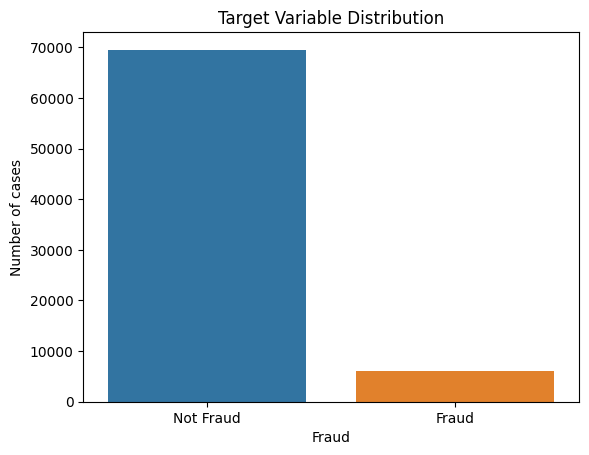

In [34]:
sns.countplot(x=train_ready['fraud'].map({0:'Not Fraud',1:'Fraud'}))
plt.title('Target Variable Distribution')
plt.xlabel('Fraud')
plt.ylabel('Number of cases')
plt.show()

## Registrations and Purchases by Day of the Week

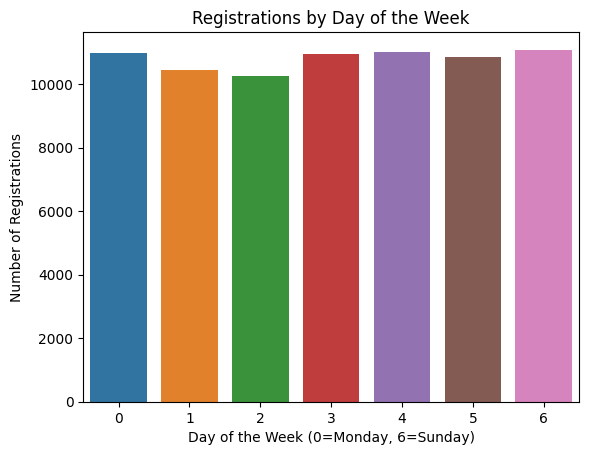

In [20]:
sns.countplot(x= train_ready['account_registration_time'].dt.weekday)
plt.title('Registrations by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Number of Registrations')
plt.show()

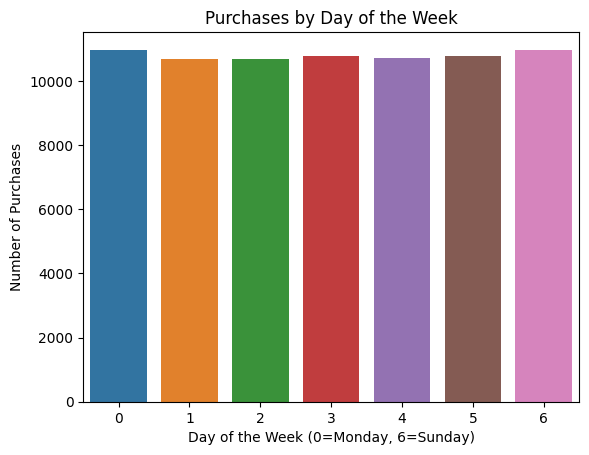

In [35]:
sns.countplot(x= train_ready['purchase_time'].dt.weekday)
plt.title('Purchases by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Number of Purchases')
plt.show()

## Purchases by Hour

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


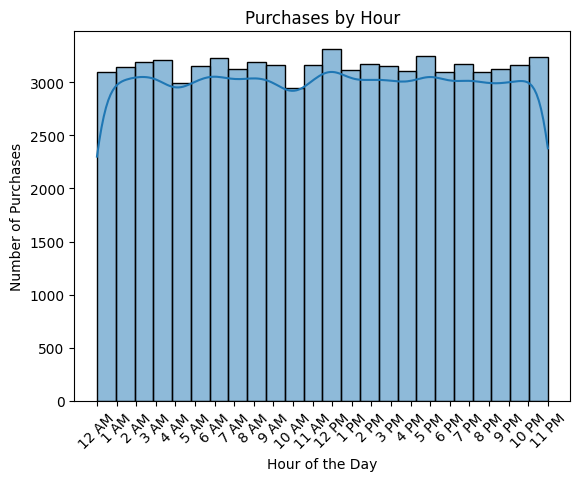

In [21]:
hour_labels = [
    '12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM',
    '6 AM', '7 AM', '8 AM', '9 AM', '10 AM', '11 AM',
    '12 PM', '1 PM', '2 PM', '3 PM', '4 PM', '5 PM',
    '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM'
]

sns.histplot(train_ready['purchase_time'].dt.hour, bins=24, kde=True)
plt.title('Purchases by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Purchases')
plt.xticks(ticks=range(0, 24), labels=hour_labels, rotation=45)
plt.show()

## Distribution of Time to Purchase

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


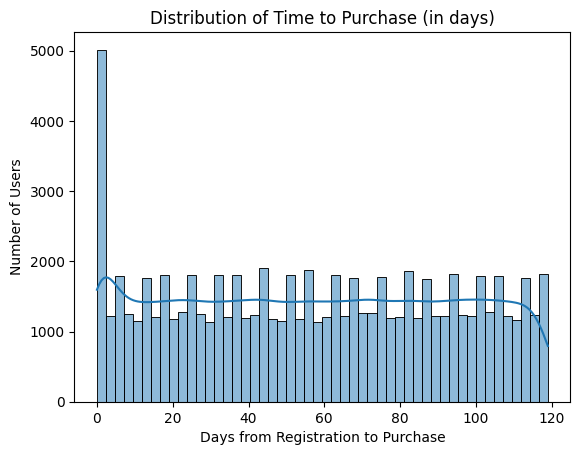

In [22]:
sns.histplot((train_ready['purchase_time'] - train_ready['account_registration_time']).dt.days, bins=50, kde=True)
plt.title('Distribution of Time to Purchase (in days)')
plt.xlabel('Days from Registration to Purchase')
plt.ylabel('Number of Users')
plt.show()

## Top 5 Countries with Highest Rate of Fraud

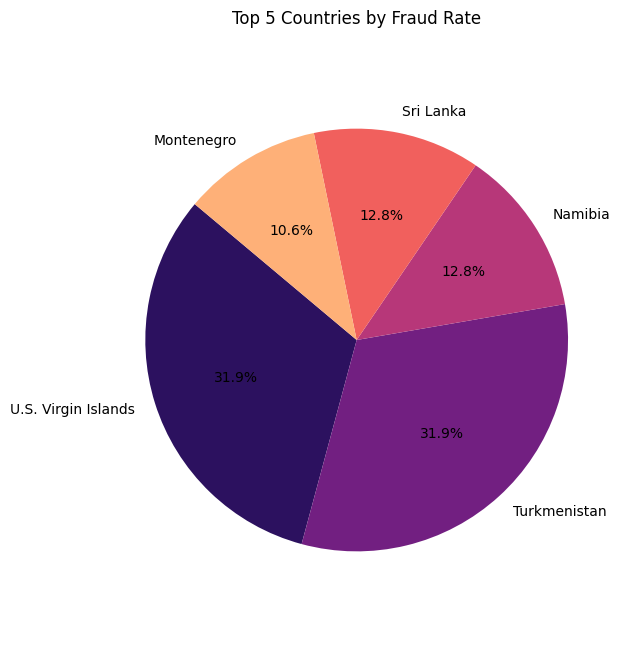

In [23]:
fraud_rate = train_ready.groupby('country')['fraud'].mean().reset_index()
fraud_rate_sorted = fraud_rate.sort_values(by='fraud', ascending=False)

top5 = fraud_rate_sorted.head(5)

pie_labels = list(top5['country'])
pie_values = list(top5['fraud'])
plt.figure(figsize=(6, 8))
plt.pie(
    pie_values,
    labels = pie_labels,
    autopct = '%1.1f%%',
    startangle = 140,
    colors = sns.color_palette('magma', len(pie_labels))
)

plt.title('Top 5 Countries by Fraud Rate')
plt.axis('equal')
plt.show()

## Top 5 Countries with Highest Total Purchase

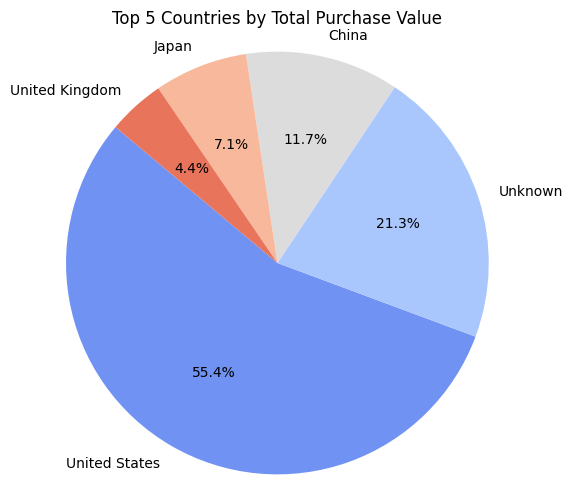

In [24]:
purchase_sum = train_ready.groupby('country')['total_purchase_value'].sum().reset_index()
top_5 = purchase_sum.sort_values(by='total_purchase_value', ascending=False).head(5)
plt.figure(figsize=(6, 6))

plt.pie(
    top_5['total_purchase_value'],
    labels = top_5['country'],
    autopct = '%1.1f%%',
    startangle = 140,
    colors = sns.color_palette('coolwarm', len(top_5))
)

plt.title('Top 5 Countries by Total Purchase Value')
plt.axis('equal')
plt.show()

## Heatmap Correlation

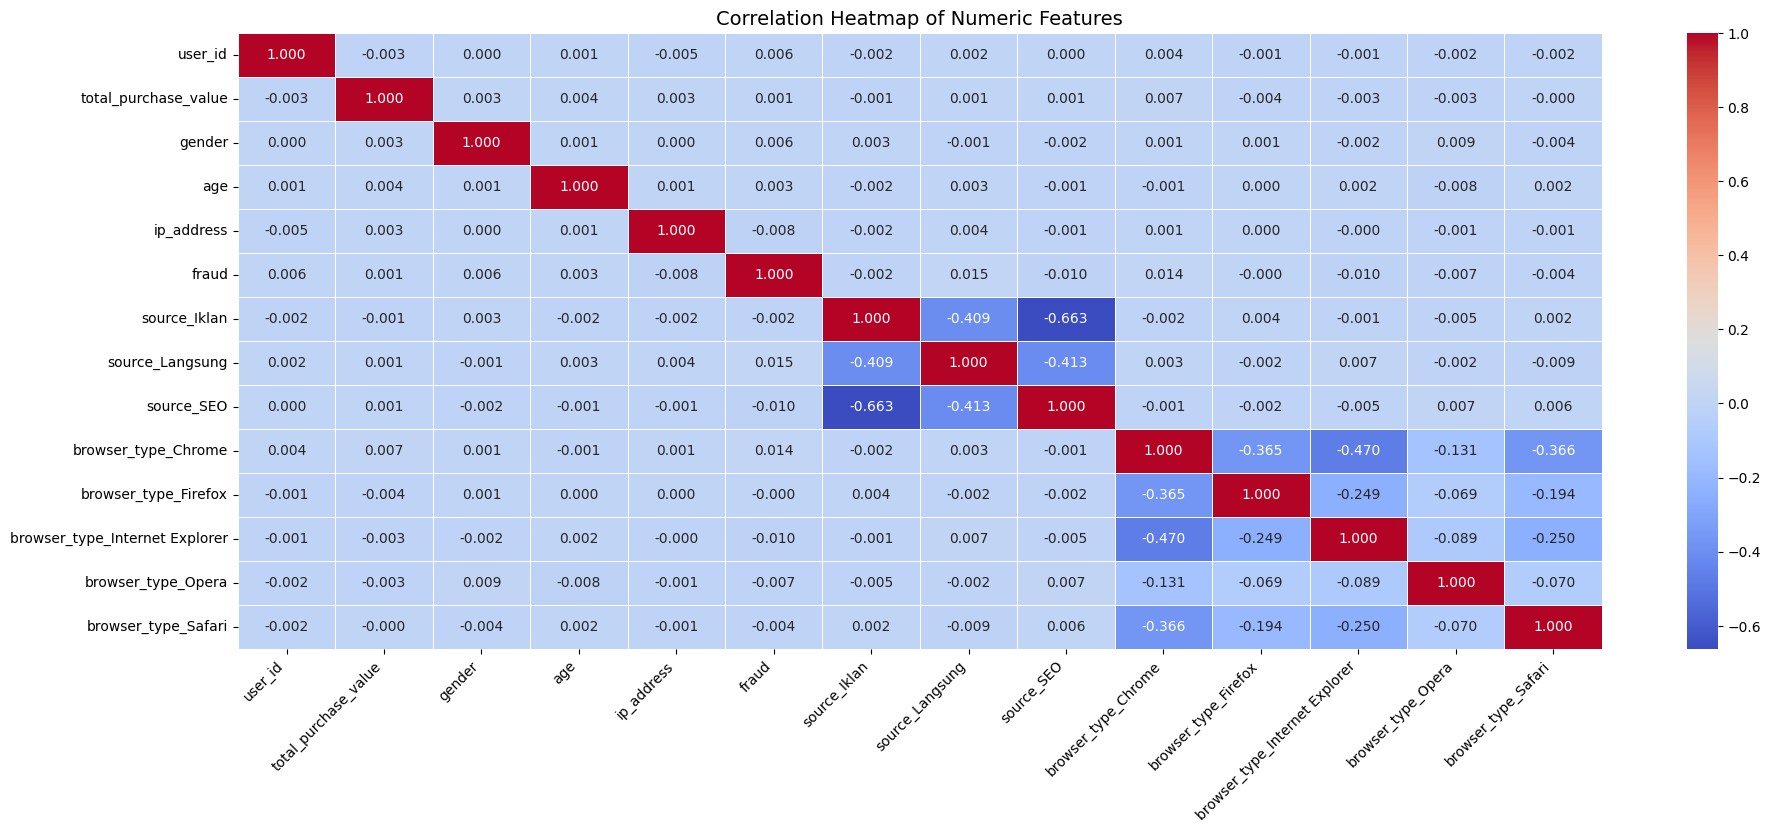

In [42]:
numeric_columns = train_ready.select_dtypes('number')
plt.figure(figsize=(22, 8))
sns.heatmap(numeric_columns.corr(), annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# Feature Engineering
---

In [52]:
train_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75556 entries, 0 to 75555
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   user_id                         75556 non-null  int64         
 1   account_registration_time       75556 non-null  datetime64[ns]
 2   purchase_time                   75556 non-null  datetime64[ns]
 3   total_purchase_value            75556 non-null  int64         
 4   device_id                       75556 non-null  object        
 5   gender                          75556 non-null  int64         
 6   age                             75556 non-null  int64         
 7   ip_address                      75556 non-null  float64       
 8   fraud                           75556 non-null  int64         
 9   source_Iklan                    75556 non-null  float64       
 10  source_Langsung                 75556 non-null  float64       
 11  so

## Age Category

In [53]:
from enum import Enum

class AgeCategory(Enum):
    YOUNG_ADULTS = 0
    ADULTS = 1
    MIDDLE_AGED = 2
    ELDERLY = 3
    OLD_AGE = 4
    VERY_OLD = 5
    OTHER = 6

def categorize_age(age):
    if 15 <= age <= 24:
        return AgeCategory.YOUNG_ADULTS.value
    elif 25 <= age <= 44:
        return AgeCategory.ADULTS.value
    elif 45 <= age <= 59:
        return AgeCategory.MIDDLE_AGED.value
    elif 60 <= age <= 74:
        return AgeCategory.ELDERLY.value
    elif 75 <= age <= 90:
        return AgeCategory.OLD_AGE.value
    elif age > 90:
        return AgeCategory.VERY_OLD.value
    else:
        return AgeCategory.OTHER.value

train_ready['age'] = train_ready['age'].apply(categorize_age)
test_ready['age'] = test_ready['age'].apply(categorize_age)
print(train_ready['age'].value_counts())

age
1    54386
0    13313
2     7657
3      200
Name: count, dtype: int64


## Date Time Features
- Extract important features from datetime features.
- Define if a user make a purchase within one hour of registration. Since fraudsters often create accounts and transacts immediately

In [54]:
def extract_time_features(df_in):
    df = df_in.copy()
    
    # Time Features (Potential seasonality pattern)
    df['reg_month'] = df['account_registration_time'].dt.month
    df['reg_day'] = df['account_registration_time'].dt.day
    df['reg_weekday'] = df['account_registration_time'].dt.weekday
    df['reg_hour'] = df['account_registration_time'].dt.hour
    df['purchase_month'] = df['purchase_time'].dt.month
    df['purchase_day'] = df['purchase_time'].dt.day
    df['purchase_weekday'] = df['purchase_time'].dt.weekday
    df['purchase_hour'] = df['purchase_time'].dt.hour

    # Difference between registration and purchase
    df['time_to_purchase_hours'] = (df['purchase_time'] - df['account_registration_time']).dt.total_seconds() / 3600
    
    # Purchase within 1 hour of registration
    df['quick_purchase'] = (df['time_to_purchase_hours'] < 1).astype(int)
    return df

train_ready = extract_time_features(train_ready)
test_ready = extract_time_features(test_ready)

print('train_ready:')
print(train_ready['quick_purchase'].value_counts())

print('test_ready:')
print(test_ready['quick_purchase'].value_counts())

train_ready:
quick_purchase
0    72278
1     3278
Name: count, dtype: int64
test_ready:
quick_purchase
0    71193
1     4363
Name: count, dtype: int64


## Fraud probability
Percentage of fraud in each country.

In [59]:
# fraud probability per country
fraud_rate_by_country = train_ready.groupby('country')['fraud'].mean().to_dict()
train_ready['fraud_rate_by_country'] = train_ready['country'].map(fraud_rate_by_country)

threshold_high = train_ready['fraud_rate_by_country'].quantile(0.95)  
threshold_low = train_ready['fraud_rate_by_country'].quantile(0.05)   

def categorize_fraud_risk(rate):
    if rate >= threshold_high:
        return 3 # High Risk
    elif rate <= threshold_low:
        return 1 # Low Risk
    else:
        return 2 # Medium Risk

train_ready['fraud_risk_category'] = train_ready['fraud_rate_by_country'].apply(categorize_fraud_risk)
print(train_ready['fraud_risk_category'].value_counts())

fraud_risk_category
2    66844
3     4830
1     3882
Name: count, dtype: int64


In [60]:
fraud_risk_list = train_ready[['country', 'fraud_risk_category']].drop_duplicates().values.tolist()
for country, risk in fraud_risk_list:
    print(f"Country: {country}, Fraud Risk Category: {risk}")

Country: China, Fraud Risk Category: 2
Country: Unknown, Fraud Risk Category: 2
Country: United States, Fraud Risk Category: 2
Country: Germany, Fraud Risk Category: 2
Country: Philippines, Fraud Risk Category: 1
Country: Chile, Fraud Risk Category: 3
Country: Korea Republic of, Fraud Risk Category: 2
Country: European Union, Fraud Risk Category: 2
Country: Spain, Fraud Risk Category: 2
Country: United Kingdom, Fraud Risk Category: 2
Country: Ireland, Fraud Risk Category: 3
Country: Canada, Fraud Risk Category: 3
Country: France, Fraud Risk Category: 2
Country: Japan, Fraud Risk Category: 2
Country: Viet Nam, Fraud Risk Category: 2
Country: Netherlands, Fraud Risk Category: 2
Country: Turkey, Fraud Risk Category: 2
Country: Ukraine, Fraud Risk Category: 3
Country: Brazil, Fraud Risk Category: 2
Country: Russian Federation, Fraud Risk Category: 1
Country: Australia, Fraud Risk Category: 2
Country: Nigeria, Fraud Risk Category: 1
Country: Hong Kong, Fraud Risk Category: 2
Country: Algeri

## High Value Transaction

If a transaction is unusually high compared to other transactions

In [57]:
train_ready['high_value_purchase'] = (train_ready['total_purchase_value'] > train_ready['total_purchase_value'].quantile(0.95)).astype(int)
print(train_ready['high_value_purchase'].value_counts())

high_value_purchase
0    71797
1     3759
Name: count, dtype: int64


## Heatmap Correlation (Post Feature Engineering)

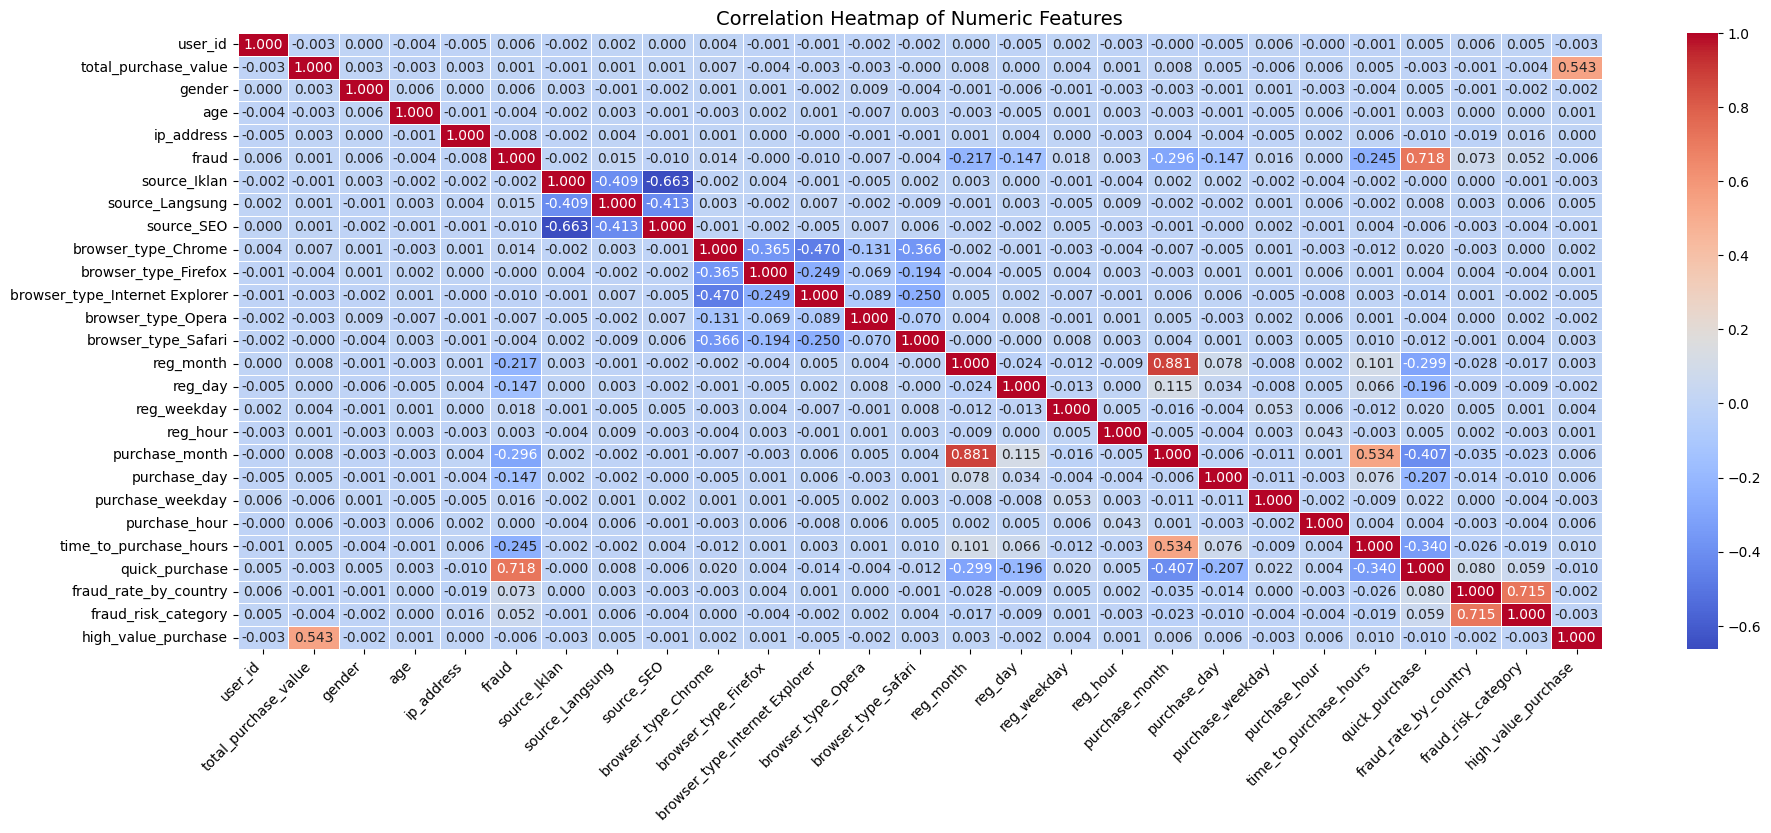

In [61]:
numeric_columns = train_ready.select_dtypes('number')
plt.figure(figsize=(22, 8))
sns.heatmap(numeric_columns.corr(), annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# Modelling
---

In [ ]:
# assignment selanjutnya